In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import os.path as osp
import sys
import glob
import time
import timeit
import math
import random

import itertools
import collections
from collections import OrderedDict

import re
from lxml import etree
from tqdm import tqdm, tnrange, tqdm_notebook

import numpy as np
import pandas as pd
import cv2
import imgaug as ia
from imgaug import augmenters as iaa
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch import Tensor
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split, Subset

from draw import show_img, show_img_grid
from utils import postprocessing, letterbox_transforms, letterbox_label_reverse, fill_label_np_tensor
from boundingbox import CoordinateType, FormatType, BoundingBoxConverter
from transforms import IaaAugmentations, IaaLetterbox, ToTensor, Compose, \
                       iaa_hsv_aug, iaa_random_crop, iaa_letterbox
from dataset import COCODataset, ImageFolderDataset, DataHelper
from dataset import worker_init_fn, variable_shape_collate_fn

In [2]:
seed = 0

def set_seed(seed):
    cudnn.benchmark = False
    cudnn.deterministic = True

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
set_seed(seed)

# Download COCO dataset

Run "get_coco_dataset.sh" to download the training data if you haven't already

In [3]:
#Uncomment to run bash script
#!./data/get_coco_dataset.sh

In [4]:
def load_coco(path):
    with open(path) as f:
        return [line.rstrip("\n") for line in f.readlines()]

In [5]:
coco_path = './coco.names'
classes_names = load_coco(coco_path)

# Paths

In [6]:
CUDA = True
use_cuda = True
weight_path = './yolov3.weights'
backbone_weight_path = './darknet53.conv.74'
coco_path = './data/coco.names'
train_target_txt = "./data/coco/trainvalno5k.txt"
valid_target_txt = "./data/coco/5k.txt"

# Build target tensor to train against

## Multi box IOU calcuation

In [7]:
# mode - x1y1x2y2, cxcywh
def bbox_iou(b1, b2, mode="x1y1x2y2"):
    if mode == "x1y1x2y2":
        b1_x1, b1_y1, b1_x2, b1_y2 = b1[...,0], b1[...,1], b1[...,2], b1[...,3]
        b2_x1, b2_y1, b2_x2, b2_y2 = b2[...,0], b2[...,1], b2[...,2], b2[...,3]  
    elif mode == "cxcywh":
        b1_x1, b1_x2 = b1[..., 0] - b1[..., 2] / 2, b1[..., 0] + b1[..., 2] / 2
        b1_y1, b1_y2 = b1[..., 1] - b1[..., 3] / 2, b1[..., 1] + b1[..., 3] / 2
        b2_x1, b2_x2 = b2[..., 0] - b2[..., 2] / 2, b2[..., 0] + b2[..., 2] / 2
        b2_y1, b2_y2 = b2[..., 1] - b2[..., 3] / 2, b2[..., 1] + b2[..., 3] / 2
    
    num_b1 = b1.shape[0]
    num_b2 = b2.shape[0]
    
    inter_x1 = torch.max(b1_x1.unsqueeze(1).repeat(1, num_b2), b2_x1)
    inter_y1 = torch.max(b1_y1.unsqueeze(1).repeat(1, num_b2), b2_y1)
    inter_x2 = torch.min(b1_x2.unsqueeze(1).repeat(1, num_b2), b2_x2)
    inter_y2 = torch.min(b1_y2.unsqueeze(1).repeat(1, num_b2), b2_y2)
            
    inter_area = torch.clamp(inter_x2 - inter_x1, min=0) * torch.clamp(inter_y2 - inter_y1, min=0)
    b1_area = (b1_x2 - b1_x1) * (b1_y2 - b1_y1)
    b2_area = (b2_x2 - b2_x1) * (b2_y2 - b2_y1)
    union_area = b1_area.unsqueeze(1).repeat(1, num_b2) + b2_area.unsqueeze(0).repeat(num_b1, 1) - inter_area
    
    iou = inter_area / union_area
    return iou

## Yolo Loss layer

In [8]:
class YoloLayer(nn.Module):
    def __init__(self, anchors_all, anchors_mask, img_dim, numClass):
        super().__init__()
        self.anchors_all = anchors_all
        self.anchors_mask = anchors_mask
        self.img_dim = img_dim
                
        self.numClass = numClass
        self.bbox_attrib = 5 + numClass
        
        self.lambda_xy = 1
        self.lambda_wh = 1
        self.lambda_conf = 1 #1.0
        self.lambda_cls = 1 #1.0
        
        self.obj_scale = 1 #5
        self.noobj_scale = 1 #1
        
        self.ignore_thres = 0.7
        
        self.mseloss = nn.MSELoss(reduction='sum')
        self.bceloss = nn.BCELoss(reduction='sum')
        self.bceloss_average = nn.BCELoss(reduction='elementwise_mean')
 
    def forward(self, x, img_dim, target=None):
        #x : bs x nA*(5 + num_classes) * h * w
        nB = x.shape[0]
        nA = len(self.anchors_mask)
        nH, nW = x.shape[2], x.shape[3]
        stride = img_dim[1] / nH
        anchors_all = torch.FloatTensor(self.anchors_all) / stride 
        anchors = anchors_all[self.anchors_mask]
        # print(anchors)
        
        #Reshape predictions from [B x [A * (5 + numClass)] x H x W] to [B x A x H x W x (5 + numClass)]
        preds = x.view(nB, nA, self.bbox_attrib, nH, nW).permute(0, 1, 3, 4, 2).contiguous()
        
        # tx, ty, tw, wh
        preds_xy = preds[..., :2].sigmoid()
        preds_wh = preds[..., 2:4]
        preds_conf = preds[..., 4].sigmoid()
        preds_cls = preds[..., 5:].sigmoid()
        
        # Calculate cx, cy, anchor mesh
        mesh_x = torch.arange(nW).repeat(nH,1).unsqueeze(2)
        mesh_y = torch.arange(nH).repeat(nW,1).t().unsqueeze(2)
        mesh_xy = torch.cat((mesh_x,mesh_y), 2).float()
        mesh_anchors = anchors.view(1, nA, 1, 1, 2).repeat(1, 1, nH, nW, 1)
        
        # pred_boxes holds bx,by,bw,bh
        pred_boxes = torch.FloatTensor(preds[..., :4].shape)
        pred_boxes[..., :2] = preds_xy.detach().cpu() + mesh_xy # sig(tx) + cx
        pred_boxes[..., 2:4] = preds_wh.detach().cpu().exp() * mesh_anchors  # exp(tw) * anchor

        # print(target.shape)
        # print(target)
        
        if target is not None:
            obj_mask, noobj_mask, box_coord_mask, \
            tconf, tcls, tx, ty, tw, th,    \
            nCorrect, nGT = self.build_target_tensor(pred_boxes, target.detach().cpu(),
                                                     anchors_all, anchors, (nH, nW), self.numClass,
                                                     self.ignore_thres)
            
            #recall = float(nCorrect / nGT) if nGT else 1
            #assert(nGT == TP + FN)

            # masks for loss calculations
            obj_mask, noobj_mask = obj_mask.cuda(), noobj_mask.cuda()
            box_coord_mask = box_coord_mask.cuda()
            cls_mask = (obj_mask == 1)
            tconf, tcls = tconf.cuda(), tcls.cuda()
            tx, ty, tw, th = tx.cuda(), ty.cuda(), tw.cuda(), th.cuda()


            loss_x = self.lambda_xy * self.mseloss(preds_xy[..., 0] * box_coord_mask, tx * box_coord_mask) / 2
            loss_y = self.lambda_xy * self.mseloss(preds_xy[..., 1] * box_coord_mask, ty * box_coord_mask) / 2
            loss_w = self.lambda_wh * self.mseloss(preds_wh[..., 0] * box_coord_mask, tw * box_coord_mask) / 2
            loss_h = self.lambda_wh * self.mseloss(preds_wh[..., 1] * box_coord_mask, th * box_coord_mask) / 2

            loss_conf = self.lambda_conf * \
                        ( self.obj_scale * self.bceloss(preds_conf * obj_mask, obj_mask) + \
                          self.noobj_scale * self.bceloss(preds_conf * noobj_mask, noobj_mask * 0) ) / 1
            loss_cls = self.lambda_cls * self.bceloss(preds_cls[cls_mask], tcls[cls_mask]) / 1
            loss =  loss_x + loss_y + loss_w + loss_h + loss_conf + loss_cls 
                
            return loss, loss.item() / nB, loss_x.item() / nB, loss_y.item() / nB, loss_w.item() / nB, loss_h.item() / nB, \
                   loss_conf.item() / nB, loss_cls.item() / nB, \
                   nCorrect, nGT
           
        # Return predictions if not training 
        out = torch.cat((pred_boxes.cuda() * stride, 
                         preds_conf.cuda().unsqueeze(4),
                         preds_cls.cuda() ), 4)
        
        # Reshape predictions from [B x A x H x W x (5 + numClass)] to [B x [A x H x W] x (5 + numClass)]
        # such that predictions at different strides could be concatenated on the same dimension
        out = out.permute(0, 2, 3, 1, 4).contiguous().view(nB, nA*nH*nW, self.bbox_attrib)
        return out

    def build_target_tensor(self, pred_boxes, target, anchors_all, anchors, inp_dim, numClass, ignore_thres):
        nB = target.shape[0]
        nA = len(anchors)
        nH, nW = inp_dim[0], inp_dim[1]
        nCorrect = 0
        nGT = 0
        target = target.float()

        obj_mask = torch.zeros(nB, nA, nH, nW, requires_grad=False)
        noobj_mask = torch.ones(nB, nA, nH, nW, requires_grad=False)
        box_coord_mask = torch.zeros(nB, nA, nH, nW, requires_grad=False)
        tconf= torch.zeros(nB, nA, nH, nW, requires_grad=False)
        tcls= torch.zeros(nB, nA, nH, nW, numClass, requires_grad=False)
        tx = torch.zeros(nB, nA, nH, nW, requires_grad=False)
        ty = torch.zeros(nB, nA, nH, nW, requires_grad=False)
        tw = torch.zeros(nB, nA, nH, nW, requires_grad=False)
        th = torch.zeros(nB, nA, nH, nW, requires_grad=False)

        for b in range(nB):
            for t in range(target.shape[1]):
                if target[b, t].sum() == 0:
                    break;
               
                gx = target[b, t, 1] * nW
                gy = target[b, t, 2] * nH
                gw = target[b, t, 3] * nW
                gh = target[b, t, 4] * nH
                gi = int(gx)
                gj = int(gy)

                # pred_boxes - [A x H x W x 4]  
                # Do not train for objectness(noobj) if anchor iou > threshold.
                tmp_gt_boxes = torch.FloatTensor([gx, gy, gw, gh]).unsqueeze(0)
                tmp_pred_boxes = pred_boxes[b].view(-1, 4)
                tmp_ious, _ = torch.max(bbox_iou(tmp_pred_boxes, tmp_gt_boxes, mode="cxcywh"), 1)
                ignore_idx = (tmp_ious > ignore_thres).view(nA, nH, nW)
                noobj_mask[b][ignore_idx] = 0
                
                #find best fit anchor for each ground truth box
                tmp_gt_boxes = torch.FloatTensor([[0, 0, gw, gh]])
                tmp_anchor_boxes = torch.cat((torch.zeros(len(anchors_all), 2), anchors_all), 1)
                tmp_ious = bbox_iou(tmp_anchor_boxes, tmp_gt_boxes, mode="cxcywh")
                best_anchor = torch.argmax(tmp_ious, 0).item()

                # If the best_anchor belongs to this yolo_layer
                if best_anchor in self.anchors_mask:
                    best_anchor = self.anchors_mask.index(best_anchor)
                    #find iou for best fit anchor prediction box against the ground truth box
                    tmp_gt_box = torch.FloatTensor([gx, gy, gw, gh]).unsqueeze(0)
                    tmp_pred_box = pred_boxes[b, best_anchor, gj, gi].view(-1, 4)
                    tmp_iou = bbox_iou(tmp_gt_box, tmp_pred_box, mode="cxcywh")

                    if tmp_iou > 0.5:
                        nCorrect += 1
                   
                    box_coord_mask[b, best_anchor, gj, gi] = math.sqrt(2 - target[b, t, 3] * target[b, t, 4]) # Larger gradient for small objects
                    obj_mask[b, best_anchor, gj, gi] = 1
                    tconf[b, best_anchor, gj, gi] = 1
                    tcls[b, best_anchor, gj, gi, int(target[b, t, 0])] = 1
                    tx[b, best_anchor, gj, gi] = gx - gi
                    ty[b, best_anchor, gj, gi] = gy - gj
                    tw[b, best_anchor, gj, gi] = torch.log(gw / anchors[best_anchor, 0] + 1e-16)
                    th[b, best_anchor, gj, gi] = torch.log(gh / anchors[best_anchor, 1] + 1e-16)

                    nGT += 1
        return obj_mask, noobj_mask, box_coord_mask, tconf, tcls, tx, ty, tw, th, nCorrect, nGT

## Modify YoloNet (from yolo_detect.ipynb)

In [9]:
import darknet
from darknet import Darknet, PreDetectionConvGroup, UpsampleGroup, WeightManager

class YoloNet(nn.Module):
    def __init__(self, img_dim, anchors = [10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326], numClass=80):
        super().__init__()
        nin = 32
        self.numClass = numClass
        self.img_dim = img_dim
        self.stat_keys = ['loss', 'loss_x', 'loss_y', 'loss_w', 'loss_h', 'loss_conf', 'loss_cls',
                          'nCorrect', 'nGT', 'recall']
        
        anchors = [(anchors[i], anchors[i+1]) for i in range(0,len(anchors),2)]
        # anchors = [anchors[i:i+3] for i in range(0, len(anchors), 3)][::-1]
                
        self.feature = Darknet([1,2,8,8,4])
        self.feature.addCachedOut(61)
        self.feature.addCachedOut(36)
        
        self.pre_det1 = PreDetectionConvGroup(1024, 512, numClass=self.numClass)
        self.yolo1 = YoloLayer(anchors, [6, 7, 8], img_dim, self.numClass)
        self.pre_det1.addCachedOut(-3) #Fetch output from 4th layer backward including yolo layer
        
        self.up1 = UpsampleGroup(512)
        self.pre_det2 = PreDetectionConvGroup(768, 256, numClass=self.numClass)
        self.yolo2 = YoloLayer(anchors, [3, 4, 5], img_dim, self.numClass)
        self.pre_det2.addCachedOut(-3)
        
        self.up2 = UpsampleGroup(256)
        self.pre_det3 = PreDetectionConvGroup(384, 128, numClass=self.numClass)
        self.yolo3 = YoloLayer(anchors, [0, 1, 2], img_dim, self.numClass)
        
        
        
    def forward(self, x, target=None):
        img_dim = (x.shape[3], x.shape[2])
        #Extract features
        out = self.feature(x)
                
        #Detection layer 1
        out = self.pre_det1(out)
        det1 = self.yolo1(out, img_dim, target)
        
        #Upsample 1
        r_head1 = self.pre_det1.getCachedOut(-3)
        r_tail1 = self.feature.getCachedOut(61)
        out = self.up1(r_head1,r_tail1)
                
        #Detection layer 2
        out = self.pre_det2(out)
        det2 = self.yolo2(out, img_dim, target)
        
        #Upsample 2
        r_head2 = self.pre_det2.getCachedOut(-3)
        r_tail2 = self.feature.getCachedOut(36)
        out = self.up2(r_head2,r_tail2)
                
        #Detection layer 3
        out = self.pre_det3(out)
        det3 = self.yolo3(out, img_dim, target)
        
        if target is not None:
            loss, *out = [sum(det) for det in zip(det1, det2, det3)]
            self.stats = dict(zip(self.stat_keys, out))
            self.stats['recall'] = self.stats['nCorrect'] / self.stats['nGT'] if self.stats['nGT'] else 0
            return loss
        else:
            return det1, det2, det3
    
    # Format : pytorch / darknet
    def saveWeight(self, weights_path, format='pytorch'):
        if format == 'pytorch':
            torch.save(self.state_dict(), weights_path)
        elif format == 'darknet':
            raise NotImplementedError
    
    def loadWeight(self, weights_path, format='pytorch'):
        if format == 'pytorch':
            weights = torch.load(weights_path, map_location=lambda storage, loc: storage)
            self.load_state_dict(weights)
        elif format == 'darknet':
            wm = WeightManager(self)
            wm.loadWeight(weights_path)

# Training

## Set up data (refer to COCODataset.ipynb/Deterministic_data_loading.ipynb)

In [10]:
def getTransforms(dim, aug=True):
    if aug:
        transform = Compose([IaaAugmentations([iaa_hsv_aug(0.1, 1.5, 1.5),
                                               iaa_random_crop(0.3),
                                               iaa.Fliplr(0.5),
                                               iaa.Scale(dim)
                                              ]),
                             ToTensor()])
    else:
        transform = Compose([IaaAugmentations([iaa.Scale(dim)
                                              ]),
                             ToTensor()])
    return transform

In [11]:
def get_trans_fn(aug):
    def getTransformByDim(dim):
        return getTransforms(dim, aug=aug)
    return getTransformByDim

In [12]:
def getCOCOData(seed, train_target_txt, bs, aug=True,
                subset_idx=None, shuffle=True, cyclic=True, dim=None, rand_dim_interval=None,
                max_net_batches=None, net_subdivisions=1):
    torch.manual_seed(seed)
    trans_fn = lambda dim: getTransforms(dim, aug)
    coco_ds = COCODataset(train_target_txt, bs, subset_idx=subset_idx, trans_fn=trans_fn,
                          shuffle=shuffle, cyclic=cyclic, dim=dim, rand_dim_interval=rand_dim_interval)
    coco_dl = DataLoader(coco_ds, batch_size=bs, shuffle=False, num_workers=4, worker_init_fn=worker_init_fn, collate_fn=variable_shape_collate_fn)
    coco_data = DataHelper(coco_ds, coco_dl, current_batch=0, max_net_batches=max_net_batches, net_subdivisions=net_subdivisions)
    return coco_data

## Checkpoints

In [13]:
def save_checkpoint(data, net, optimizer, recorder, scheduler, model_id, weight_dir):    
    checkpoint = { 'data' : data.get_state_dict(),
                   'net' : net.state_dict(),
                   'optimizer' : optimizer.state_dict(),
                   'recorder' : recorder.state_dict(),
                   'scheduler' : scheduler.state_dict() if scheduler else None,
    }
    model_dir = osp.join(weight_dir, model_id)
    os.makedirs(model_dir, exist_ok=True)
    file_name = 'yolov3_%s_checkpoint_%.6d%s' % (model_id, data.get_net_batch(), '.pth.tar')
    torch.save(checkpoint, osp.join(model_dir, file_name))
    
def load_checkpoint(full_path):
    checkpoint = torch.load(full_path,  map_location=lambda storage, loc: storage)
    return checkpoint

def get_checkpoint_list(model_id, weight_dir):
    files_list = [f for f in glob.glob(osp.join(weight_dir, model_id, '*.*.tar'))]
    return files_list

def remove_checkpoints(model_id, weight_dir, num_remove=20, num_keep=10, remove_all=False, debug=False):
    checkpoint_list = sorted(get_checkpoint_list(model_id, weight_dir))
    if remove_all:
        for f in checkpoint_list:
            print('Deleting {}'.format(f))
            if not debug:
                os.remove(f)
    else:
        remove_items = len(checkpoint_list) - num_keep
        if remove_items >= num_remove:
            for f in checkpoint_list[:remove_items]:
                print('Deleting {}'.format(f))
                if not debug:
                    os.remove(f)
        
def get_latest_checkpoint(model_id, weight_dir):
    files_list = [f for f in glob.glob(osp.join(weight_dir, model_id, '*.*.tar'))]
    if files_list is None:
        return None, 0
    
    latest_iteration = -1
    latest_i = -1
    for i, f in enumerate(files_list):
        pattern = 'yolov3_(.+?)_checkpoint_(.+?)\.'
        m = re.search(pattern, f)
        f_id = m.group(1)
        iteration = int(m.group(2))
        if f_id == model_id and (iteration >= latest_iteration):
            latest_iteration = iteration
            latest_i = i
            
    if latest_i < 0:
        return None, 0
    else:
        return files_list[latest_i], latest_iteration       

## Display stats and progress bar

In [14]:
def get_stats_string(net_batch, epoch, recorder):
    return '{:>9d} {:>5d} {:0<9.7g} {:0<9.7g} {:0<9.7g} {:0<9.7g} {:0<9.7g} {:0<9.7g} {:0<10.7g} {:0<9.7g}' \
                         .format(net_batch, epoch, *recorder.current_stats.values())

def create_batch_progressbar(start, end):
    return tqdm(file=sys.stdout, leave=False, initial=start,  total=end)

def update_batch_progressbar(progess_bar, recorder, epoch, net_batch, batch, dim):
    progess_bar.set_description_str(get_stats_string(net_batch, epoch, recorder))
    progess_bar.set_postfix_str('Net Batch:{} Batch:{} Dim:{}'.format(net_batch, batch, str(dim)))

def print_stats(net_batch, epoch, recorder, use_tqdm=True):
    out = get_stats_string(net_batch, epoch, recorder)
    if use_tqdm:
        tqdm.write(out)
    else:
        print(out)

def print_stats_header(use_tqdm=True):
    out = "{:>9s} {:>5s} {:>9s} {:>9s} {:>9s} {:>9s} {:>9s} {:>9s} {:>10s} {:>9s}" \
          .format('Net_Batch', 'Epoch', 'loss_x', 'loss_y', 'loss_w', 'loss_h', 'loss_conf', 'loss_cls', 'loss_total','recall')
    if use_tqdm:
        tqdm.write(out)
    else:
        print(out)

def print_save_msg(net_batch, batch, use_tqdm=True):
    tqdm.write("Saving at Net Batch:{}, current_batch:{}" \
                .format(net_batch, batch))

## Recorder

In [15]:
class Recorder:
    def __init__(self):
        self.loss_keys = ['loss_x', 'loss_y', 'loss_w', 'loss_h', 'loss_conf', 'loss_cls', 'loss']
        self.metrics_keys = ['nCorrect', 'nGT']
        self.acc_keys = self.loss_keys + self.metrics_keys
        
        self.eval_keys = ['recall']
        self.current_keys = self.loss_keys + self.eval_keys
        self.ewma_keys = self.loss_keys + self.eval_keys
        
        self.ewma_stats = OrderedDict([(k, 0.0) for k in self.ewma_keys])
        self.current_stats = OrderedDict([(k, 0.0) for k in self.current_keys])
        # Not used temporarily
        # self.acc_stats = OrderedDict([(k, 0.0) for k in self.acc_keys])
        # self.eval_stats = OrderedDict([(k, 0.0) for k in self.eval_keys])
        # self.acc_datasize = 0

    def state_dict(self):
        state_dict = { 'ewma_stats': self.ewma_stats }
        return state_dict

    def load_state_dict(self, state_dict):
        self.ewma_stats = state_dict['ewma_stats']
        self.current_stats.update({k: self.ewma_stats[k] for k in self.ewma_keys}) 
        
    def on_batch_end(self, batch_stats, batch_datasize):
        # self.ewma_stats = OrderedDict({k: ewma_online(batch_stats[k], self.ewma_stats[k], 10)
        #                               if self.ewma_stats[k] != 0 else batch_stats[k]
        #                               for k in self.ewma_keys})
        
        # Temporary change: Just display current batch stats
        self.ewma_stats = OrderedDict({k: batch_stats[k] for k in self.ewma_keys})
        self.current_stats.update({k: self.ewma_stats[k] for k in self.ewma_keys}) 

    def on_epoch_end(self):
        # Supposely used to clear stats, not used at the moment
        pass

In [16]:
#Exponential weighted moving average
def ewma_online(new_value, previous_average, window):
    alpha = 2 /(window + 1.0)
    new_average = alpha * new_value + (1 - alpha) * previous_average
    return new_average

## Optimizer

In [17]:
def load_optimizer(optimizer, state_dict):
    if len(optimizer.param_groups) == len(state_dict['param_groups']):
        # Freeze backbone
        if len(optimizer.param_groups) == 1:
            state_dict['param_groups'][0].update({p: optimizer.param_groups[0][p] for p in ['lr', 'weight_decay', 'momentum']})
        # Detection layers and backbone layers
        elif len(optimizer.param_groups) == 2:
            state_dict['param_groups'][0].update({p: optimizer.param_groups[0][p] for p in ['lr', 'weight_decay', 'momentum']})
            state_dict['param_groups'][1].update({p: optimizer.param_groups[1][p] for p in ['lr', 'weight_decay', 'momentum']})
        optimizer.load_state_dict(state_dict)
    else:
        print("Optimizer not loaded")
    return optimizer

def get_optimizer(net, lr, backbone_lr, wd, momentum, freeze_backbone):
    feature_params = map(id, net.feature.parameters())
    detection_params = filter(lambda p : id(p) not in feature_params, net.parameters())
    if freeze_backbone:
        params = [
                    {"params": detection_params, "lr": lr},
                ]

        for p in net.feature.parameters():
            p.requires_grad = False
    else:
        params = [
                {"params": detection_params, "lr": lr},
                {"params": net.feature.parameters(), "lr": backbone_lr}
            ]
    optimizer = torch.optim.SGD(params, lr, weight_decay=wd, momentum=momentum)

    return optimizer

## Train function

In [18]:
def train(data, net, optimizer, recorder, 
          model_id='test', weight_dir=None, 
          checkpoint=None, checkpoint_interval=1, use_gpu=True):
    if checkpoint is not None:
        data.load_state_dict(checkpoint['data'])
        net.load_state_dict(checkpoint['net'])
        optimizer = load_optimizer(optimizer, checkpoint['optimizer'])
        recorder.load_state_dict(checkpoint['recorder'])
    
    train_impl(data, net, optimizer, recorder, None,
               model_id, weight_dir, checkpoint_interval,
               use_gpu)

In [19]:
def train_impl(data, net, optimizer, recorder, scheduler,
               model_id='test', weight_dir=None, checkpoint_interval=1,
               use_gpu=True, debug_log=False):
    batch_datasize = 0
    batch_stats = []
    optimizer.zero_grad()
    
    pbar = None
    print_stats_header()

    # data will generate mini-batches of sample
    for sample in data:
        # batch - mini-batch index, net_batch - net batch index, epoch - epoch index
        batch, net_batch, epoch = data.get_batch(), data.get_net_batch(), data.get_epoch()
        dim = sample['img'].shape

        if pbar is None or data.isStartOfEpoch():
            pbar = create_batch_progressbar(data.get_epoch_batch(), data.get_epoch_num_batches())
            update_batch_progressbar(pbar, recorder, epoch, net_batch, batch, dim)
        pbar.update()

        inp, labels = sample['img'], sample['label']
        if use_gpu:
            inp, labels = inp.cuda(), labels
        
        # Accumulate gradients for each mini-batch    
        loss = net(inp, labels)
        # loss = loss / data.net_subdivisions
        loss.backward()
        
        batch_stats.append(net.stats)
        batch_datasize += inp.shape[0] 

        nn.utils.clip_grad_norm_(net.parameters(), 1000)

        # Backpropogate for each net batch
        if ((batch+1) % data.net_subdivisions == 0):
            optimizer.step()
            optimizer.zero_grad()

            stats = {k: sum([d[k] for d in batch_stats]) / data.net_subdivisions for k in net.stat_keys}
            recorder.on_batch_end({k: stats[k] for k in recorder.ewma_keys if k in stats},
                                  batch_datasize)
            update_batch_progressbar(pbar, recorder, epoch, net_batch, batch, dim)

            if debug_log:
                print_stats(net_batch, epoch, recorder)
                print('Net Batch:{} Batch:{} Dim:{}'.format(net_batch, batch, str(dim)))

            batch_datasize = 0
            batch_stats = []

            if ((batch+1) / data.net_subdivisions) % checkpoint_interval == 0:
                print_stats(net_batch, epoch, recorder)
                save_checkpoint(data, net, optimizer, recorder, scheduler, model_id, weight_dir)
                if ((net_batch+1)/checkpoint_interval % 20) == 0:
                    print_stats_header()

        if data.isEndOfEpoch():     
            if pbar is not None:
                pbar.close()
            recorder.on_epoch_end()

    optimizer.zero_grad()

    if pbar is not None:
        pbar.close()

    print("\n[Finish] Net Batch:{}, current_batch:{}".format(data.get_net_batch(), data.get_batch()))

## Initial Training

In [20]:
# Epoch  | Net Batch
# 50     | ~91612
# 100    | ~183225
# 150    | ~274837
# 200    | ~366450
# 250    | ~458062
# 273    | ~500200

# |   ratio | lr    |      Batches    | 
# |   1     | 0.001 |      0 ~ 400000 |
# |   10    | 0.001 | 400000 ~ 450000 |
# |   100   | 0.001 | 450000 ~ 500200 |

# steps=400000,450000
# scales=.1,.1

seed = 0
sz = 416
dim = (sz, sz)
# Optimizer parameters
ratio = 1
lr = 0.001 / ratio
backbone_lr = 0.001 / ratio
momentum = 0.9
wd = 0.0005
freeze_backbone = False
# Network paramters. Increase subdivisions if GPU don't have enough memory
net_bs = 64
net_subdivisions = 8
bs = int(net_bs / net_subdivisions)
# Change image dimension every 10 net_batch -> 40 mini-batch
random_dim_interval = net_bs * 10
# Save interval in units of net batch
checkpoint_interval = 100 #100
# Maximum net batches to train, roughly around 270 epochs
max_net_batches = 500200 # 500200

In [ ]:
model_id = 'COCO_ydixon'
weight_dir = './weights'

# Remove old checkpoints, uncomment to enable 
#remove_checkpoints(model_id, weight_dir)

set_seed(seed)
net = YoloNet((sz, sz)).cuda()
net.feature.loadWeight(backbone_weight_path) # Load backbone darknet53 weight
#net.loadWeight(pt_weight_path) # Load pretrained pytorch weight
#net.loadWeight(weight_path, 'darknet') # Load full yolo v3 weight
#net.load_state_dict(old_checkpoint['net']) # Load state_dict from older versions of checkpoints

data = getCOCOData(seed, train_target_txt, bs, aug=True,
                   subset_idx=None, shuffle=True, cyclic=True, dim=None, rand_dim_interval=random_dim_interval,
                   max_net_batches=max_net_batches, net_subdivisions=net_subdivisions)
optimizer = get_optimizer(net, lr, backbone_lr, wd, momentum, freeze_backbone)
recorder = Recorder()


train(data, net, optimizer, recorder,
      model_id=model_id, weight_dir=weight_dir,
      checkpoint=None, checkpoint_interval=checkpoint_interval,
      use_gpu=True)   


## Resume training (make sure 'model_id' matches)

In [22]:
def resume_training(max_net_batches, model_id, weight_dir):
    checkpoint_path, latest_epoch = get_latest_checkpoint(model_id, weight_dir)
    #checkpoint_path='./weights/COCO_rand_4/yolov3_COCO_rand_4_checkpoint_000099.pth.tar'

    if checkpoint_path is None:
        print('No checkpoint for %s found' % model_id)
        return
    
    print('Loading %s' % checkpoint_path)
    checkpoint = load_checkpoint(checkpoint_path)
    
    data = getCOCOData(seed, train_target_txt, bs, aug=True,
                       subset_idx=None, shuffle=True, cyclic=True, dim=None, rand_dim_interval=random_dim_interval,
                       max_net_batches=max_net_batches, net_subdivisions=net_subdivisions)
    net = YoloNet((sz, sz), numClass=80).cuda()
    optimizer = get_optimizer(net, lr, backbone_lr, wd, momentum, freeze_backbone)
    recorder = Recorder()

    train(data, net, optimizer, recorder,
          model_id=model_id, weight_dir=weight_dir,
          checkpoint=checkpoint, checkpoint_interval=checkpoint_interval,
          use_gpu=True)          

In [23]:
# Epoch  | Net Batch
# 50     | ~91612
# 100    | ~183225
# 150    | ~274837
# 200    | ~366450
# 250    | ~458062
# 273    | ~500200

# |   ratio | lr    |      Batches    | 
# |   1     | 0.001 |      0 ~ 400000 |
# |   10    | 0.001 | 400000 ~ 450000 |
# |   100   | 0.001 | 450000 ~ 500200 |

# steps=400000,450000
# scales=.1,.1

seed = 0
sz = 416
dim = (sz, sz)
# Optimizer parameters
ratio = 1
lr = 0.001 / ratio
backbone_lr = 0.001 / ratio
momentum = 0.9
wd = 0.0005
freeze_backbone = False
# Network paramters. Increase subdivisions if GPU don't have enough memory
net_bs = 64
net_subdivisions = 8
bs = int(net_bs / net_subdivisions)
# Change image dimension every 10 net_batch -> 40 mini-batch
random_dim_interval = net_bs * 10
# Save interval in units of net batch
checkpoint_interval = 100 #100
# Maximum net batches to train, roughly around 270 epochs
max_net_batches = 500200 # 500200

In [22]:
model_id = 'COCO_ydixon'
weight_dir = './weights'

set_seed(seed)
resume_training(max_net_batches, model_id, weight_dir)

Loading ./weights/COCO_rand_1/yolov3_COCO_rand_1_checkpoint_000339.pth.tar
Net_Batch Epoch    loss_x    loss_y    loss_w    loss_h loss_conf  loss_cls loss_total    recall
      340     0 205.89730 292.27700 10.179990 9.3650880 111.93200 81.355370 711.006700 0.2407046:  19%|█▊        | 2730/14658 [00:06<2:20:18,  1.42it/s, Net Batch:340 Batch:2727 Dim:torch.Size([8, 3, 480, 480])]   

## Test models

In [14]:
from train import get_latest_checkpoint, load_checkpoint

### Correct yolo boxes from the network (they are  either letterboxed or scaled)

In [15]:
def letterbox_reverse(labels, org_w, org_h, new_w, new_h):
    if len(labels) == 0:
        return labels

    if isinstance(labels, torch.Tensor):
        labels = labels.clone()
    elif isinstance(labels, np.ndarray):
        labels = labels.copy()
    else:
        raise TypeError("Labels must be a numpy array or pytorch tensor")

    ratio = min(new_w / org_w, new_h / org_h)
    resize_w, resize_h = int(org_w * ratio), int(org_h * ratio)
    x_pad, y_pad = (new_w - resize_w) // 2, (new_h - resize_h) // 2

    mask = labels.sum(-1) != 0
    labels[mask, 0] = np.clip((labels[mask, 0] - x_pad) / ratio, 0, org_w)
    labels[mask, 2] = np.clip((labels[mask, 2] - x_pad) / ratio, 0, org_w)
    labels[mask, 1] = np.clip((labels[mask, 1] - y_pad) / ratio, 0, org_h)
    labels[mask, 3] = np.clip((labels[mask, 3] - y_pad) / ratio, 0, org_h)

    return labels


def rescale_bbox(labels, org_w, org_h, new_w, new_h):
    if len(labels) == 0:
        return labels

    if isinstance(labels, torch.Tensor):
        labels = labels.clone()
    elif isinstance(labels, np.ndarray):
        labels = labels.copy()
    else:
        raise TypeError("Labels must be a numpy array or pytorch tensor")

    ratio_x, ratio_y = new_w / org_w, new_h / org_h
    mask = labels.sum(-1) != 0
    labels[mask, 0] = np.clip((labels[mask, 0]) / ratio_x, 0, org_w)
    labels[mask, 2] = np.clip((labels[mask, 2]) / ratio_x, 0, org_w)
    labels[mask, 1] = np.clip((labels[mask, 1]) / ratio_y, 0, org_h)
    labels[mask, 3] = np.clip((labels[mask, 3]) / ratio_y, 0, org_h)
    
    return labels

def correct_yolo_boxes(bboxes, org_w, org_h, img_w, img_h, is_letterbox=False):
    if is_letterbox:
        bboxes = letterbox_reverse(bboxes, org_w, org_h, img_w, img_h)
    else:
        bboxes = rescale_bbox(bboxes, org_w, org_h, img_w, img_h)

    bboxes = BoundingBoxConverter.convert(bboxes, 
                                          CoordinateType.Absolute, FormatType.x1y1x2y2,
                                          CoordinateType.Absolute, FormatType.xywh,
                                          img_dim=(img_w, img_h))
    return bboxes

### Convert tensors to format acceptable by PLT

In [16]:
def prep_img_for_plt(img_list):
    if isinstance(img_list, collections.abc.Sequence):
        img_list = [img.permute(1,2,0).numpy() for img in img_list] 
    else:
        img_list = img_list.permute(0,2,3,1).cpu().numpy()
        img_list = [img for img in img_list]
    return img_list

## Pass images to the network and collect the predictions into a list

In [17]:
def predict(data, net, num_classes=80, is_letterbox=True):
    img_list, preds_list = [], []
    with torch.no_grad(): 
        for sample in data:
            imgs, org_imgs, labels = sample['img'].cuda(), sample['org_img'], sample['label']

            # Pass images to the network
            det1, det2, det3 = net(imgs, None)
            predictions = postprocessing(torch.cat((det1,det2,det3), 1), num_classes, obj_conf_thr=0.5, nms_thr=0.4, is_eval=False, use_nms=True)

            for img, org_img, prediction in zip(imgs, org_imgs, predictions):
                img_w, img_h, org_w, org_h = img.shape[2], img.shape[1], org_img.shape[2], org_img.shape[1]
                if prediction is not None and len(prediction) != 0:
                    bboxes = correct_yolo_boxes(prediction[..., 0:4], org_w, org_h, img_w, img_h, is_letterbox)
                    prediction = torch.cat((prediction[..., 6:7], bboxes), -1)

                preds_list += [prediction.cpu().numpy()]
            img_list += prep_img_for_plt(org_imgs)
    return img_list, preds_list

### Display images and predictions on a grid

In [18]:
from draw import show_img_grid

def show_detections(data, net, classes_names, cols=2, is_letterbox=True):
    img_list, preds_list = predict(data, net, num_classes=len(classes_names), is_letterbox=is_letterbox)
    show_img_grid(img_list, cols=cols, classes=classes_names, labels_list=preds_list)

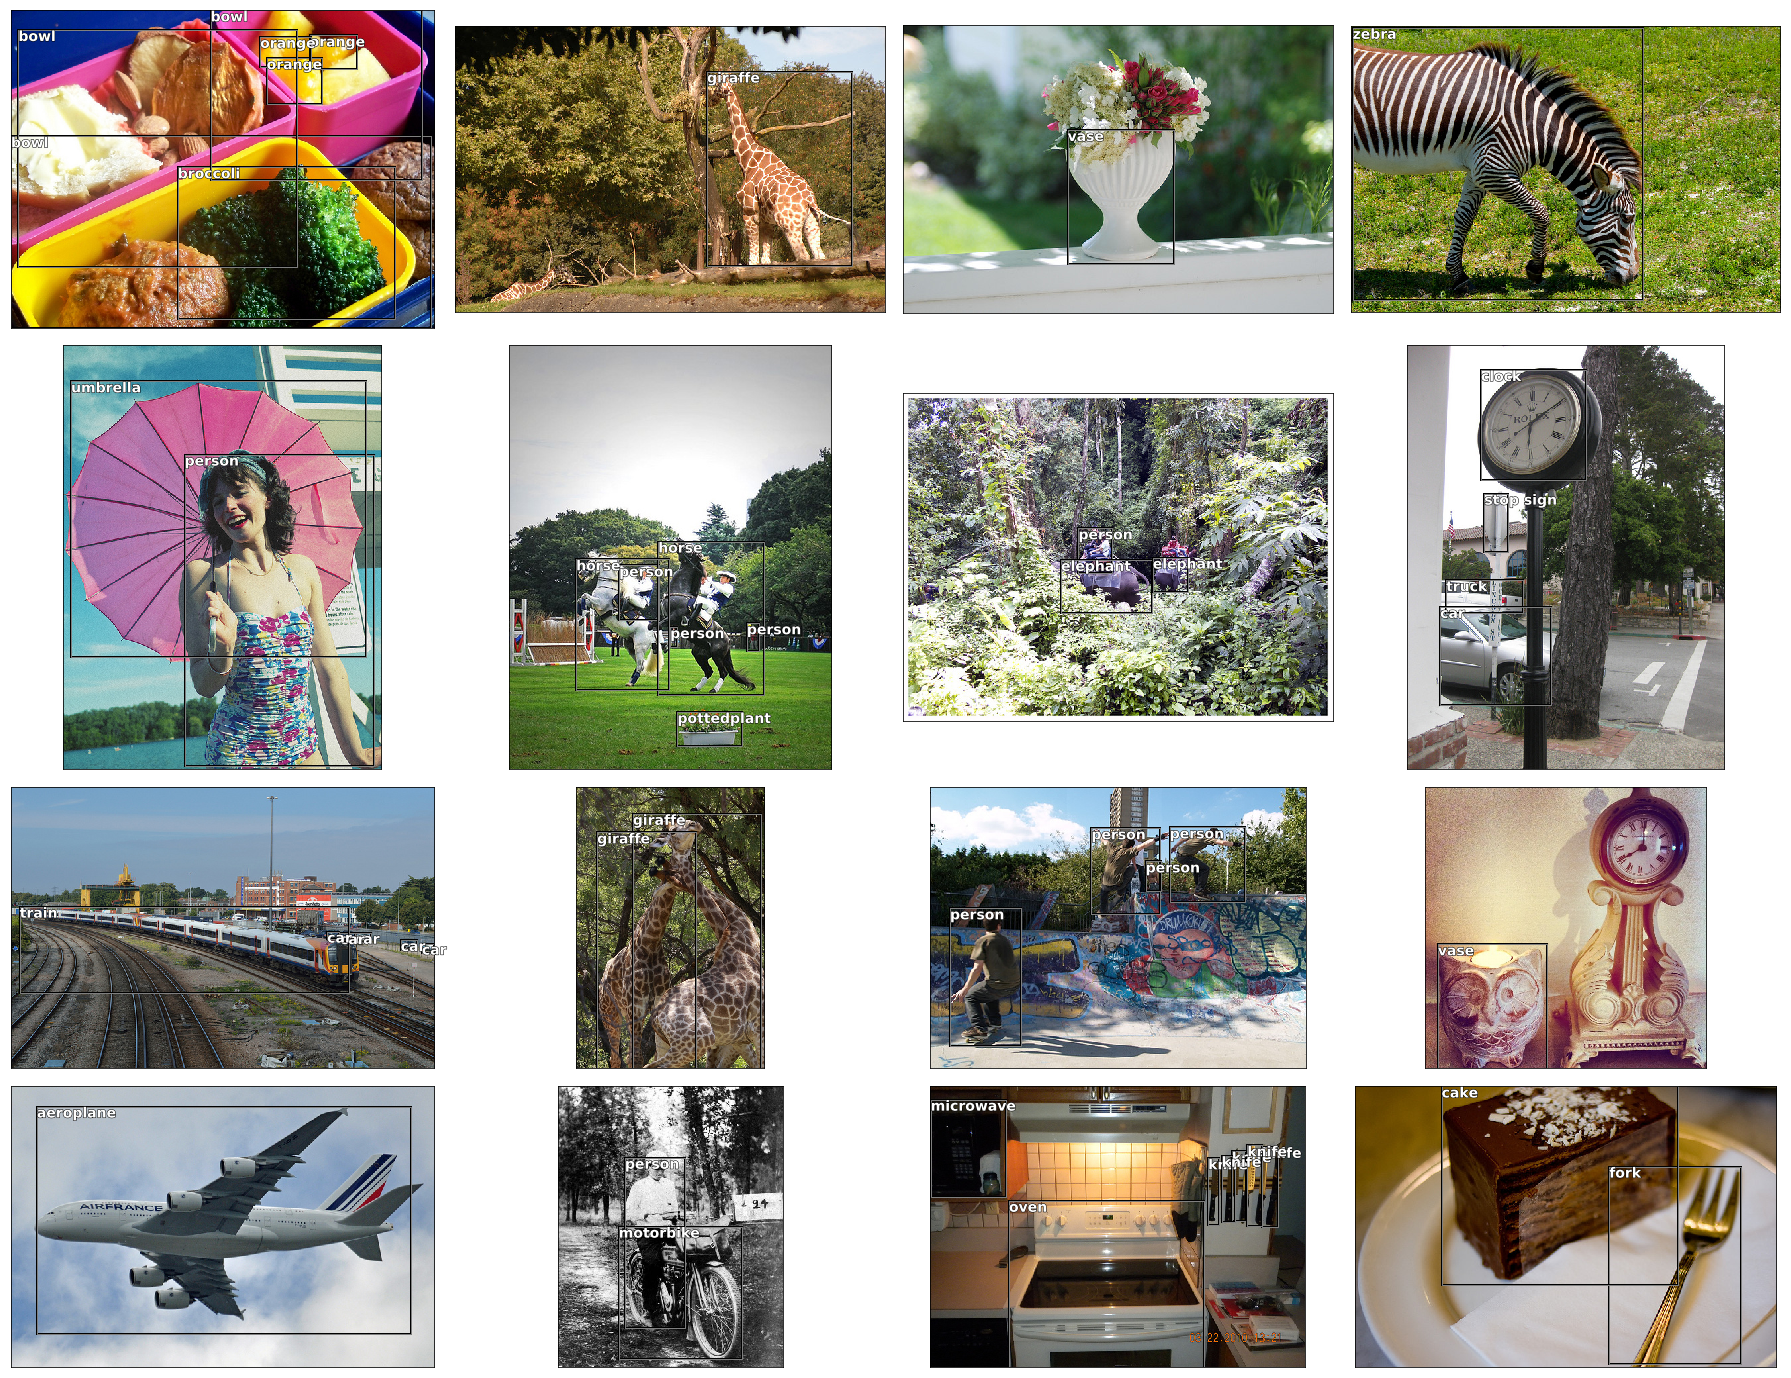

In [19]:
# Display subset of the training set
model_id = 'COCO_ydixon'
bs = 8
sz = 416
dim = (sz, sz)

nImgShow  = 16
start_idx = 0
end_idx = start_idx + nImgShow
dataset_subset_idx = np.arange(start_idx, end_idx)


weight_dir = './weights'

classes_names = load_coco(coco_path)

checkpoint = load_checkpoint(get_latest_checkpoint(model_id, weight_dir)[0])
coco_data = getCOCOData(seed, train_target_txt, bs, aug=False,
                       subset_idx=dataset_subset_idx, shuffle=False, cyclic=False, dim=dim, rand_dim_interval=None,
                       max_net_batches=None, net_subdivisions=1)
net = YoloNet(dim, numClass=80).cuda().eval()
net.load_state_dict(checkpoint['net'])

show_detections(coco_data, net, classes_names, cols=4, is_letterbox=False)

## Side by side comparision (Labels, official weights, model)

### Stack imgs/predictions/labels into separate lists

In [20]:
import itertools

def predict_multiple(data, nets, num_classes=80, is_letterbox=True):
    img_list = []
    preds_list = [[] for i in range(len(nets))]
    labels_list = []
    with torch.no_grad(): 
        for sample in data:
            imgs, org_imgs, labels = sample['img'].cuda(), sample['org_img'], sample['label']

            for i, net in enumerate(nets):
                det1, det2, det3 = net(imgs, None)
                predictions = postprocessing(torch.cat((det1,det2,det3), 1), num_classes, obj_conf_thr=0.5, nms_thr=0.4, is_eval=False, use_nms=True)

                for img, org_img, prediction in zip(imgs, org_imgs, predictions):
                    img_w, img_h, org_w, org_h = img.shape[2], img.shape[1], org_img.shape[2], org_img.shape[1]

                    if prediction is not None and len(prediction) != 0:
                        # bboxes = correct_yolo_boxes(prediction[..., 0:4], org_w, org_h, img_w, img_h, is_letterbox)
                        prediction = torch.cat((prediction[..., 6:7], prediction[..., 0:4]), -1)
                        prediction = BoundingBoxConverter.convert(prediction, CoordinateType.Absolute, FormatType.x1y1x2y2,
                                                      CoordinateType.Absolute, FormatType.xywh,
                                                      np.array([1,2,3,4]), (416,416))
                    preds_list[i] += [prediction.cpu().numpy()]


            img_list += prep_img_for_plt(imgs)
            for img, org_img, label in zip(imgs, org_imgs, labels):
                img_w, img_h, org_w, org_h = img.shape[2], img.shape[1], org_img.shape[2], org_img.shape[1]

                bboxes = label[..., 1:5]
                # bboxes = correct_yolo_boxes(bboxes, org_w, org_h, img_w, img_h, is_letterbox)
                # if is_letterbox:
                #     bboxes = letterbox_reverse(bboxes, org_w, org_h, img_w, img_h)
                # else:
                #     bboxes = rescale_bbox(bboxes, org_w, org_h, img_w, img_h)

                label[..., 1:5] = BoundingBoxConverter.convert(bboxes, 
                                                      CoordinateType.Relative, FormatType.cxcywh,
                                                      CoordinateType.Absolute, FormatType.xywh,
                                                      img_dim=(img_w, img_h))
                labels_list += [label.numpy()]
    return img_list, preds_list, labels_list

def show_detections_comparisons(model_id, nets, data, classes_names, is_letterbox=False, cols=0):
    img_list, preds_list, labels_list = predict_multiple(data, nets, num_classes=len(classes_names), is_letterbox=is_letterbox)
    
    show_img_list = [x for x in itertools.chain.from_iterable(itertools.zip_longest(img_list, img_list, img_list))]
    show_preds_list = [x for x in itertools.chain.from_iterable(itertools.zip_longest(labels_list, *preds_list))]
    
    cols = len(nets) + 1 if not cols else cols
    show_img_grid(show_img_list, cols=cols, classes=classes_names, labels_list=show_preds_list,
                  col_title_dict= { 'title': ['Labels', 'Darknet', 'Test Model'],
                                    'pad': 20,
                                    'fontsize': 40,
                                    'fontweight': 20,
                                    })

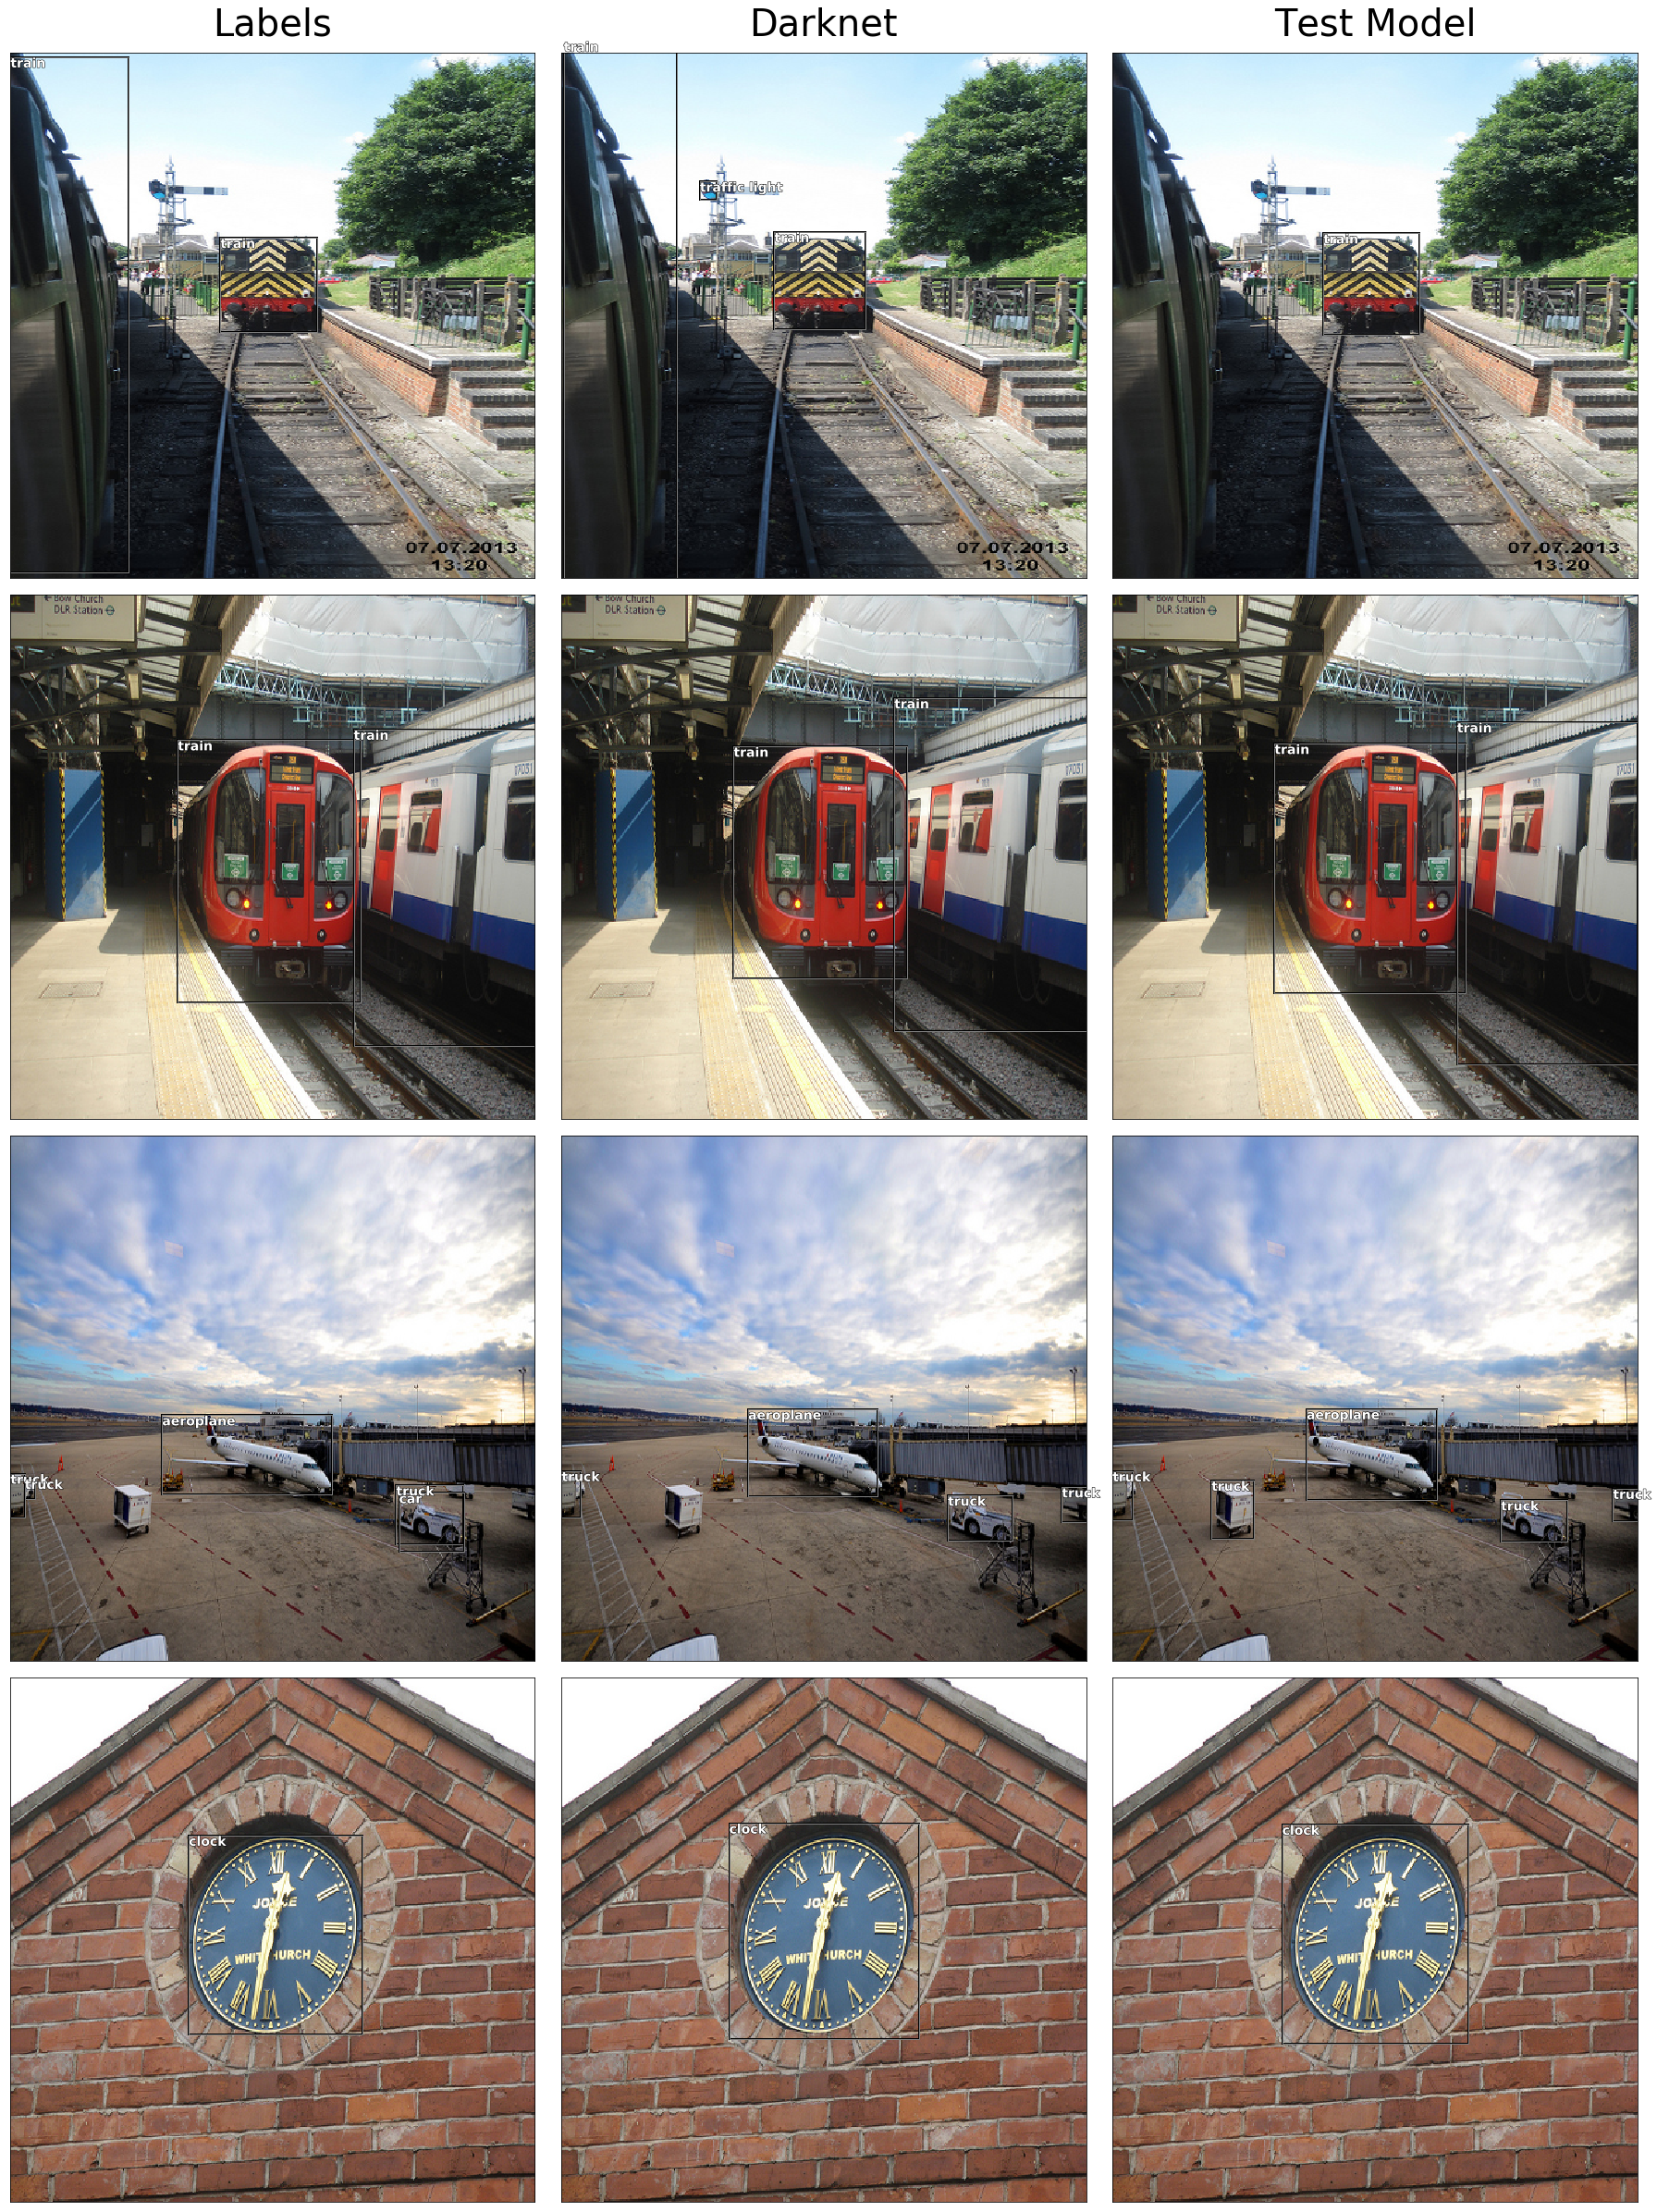

In [22]:
model_id = 'COCO_ydixon'
bs = 4

nImgShow  = 4
start_idx = 20
end_idx = start_idx + nImgShow
dataset_subset_idx = np.arange(start_idx, end_idx)

# Model weights
weight_dir = './weights'
checkpoint = load_checkpoint(get_latest_checkpoint(model_id, weight_dir)[0])

# Initialize network
darknet_model = YoloNet(dim, numClass=80).cuda().eval()
darknet_model.loadWeight(weight_path, 'darknet') 

test_model = YoloNet(dim, numClass=80).cuda().eval()
test_model.load_state_dict(checkpoint['net'])

nets_list = [darknet_model, test_model]


# COCO data
coco_data = getCOCOData(seed, valid_target_txt, bs, aug=False,
                       subset_idx=dataset_subset_idx, shuffle=False, cyclic=False, dim=dim, rand_dim_interval=None,
                       max_net_batches=None, net_subdivisions=1)

show_detections_comparisons(model_id, nets_list,
                            coco_data, classes_names, is_letterbox=False)

## Test on images

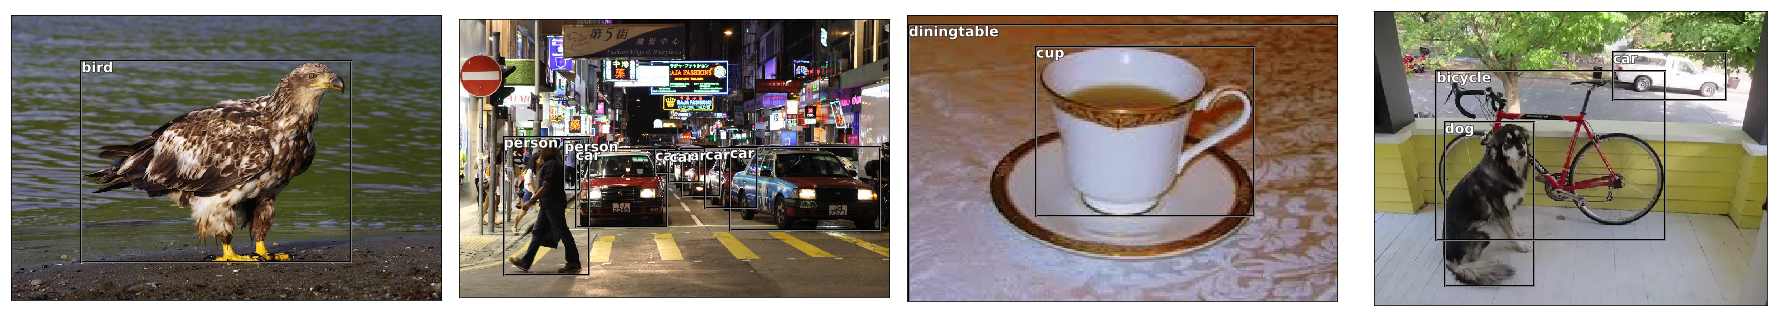

In [24]:
model_id = 'COCO_ydixon'
weight_dir = './weights'

bs = 8
sz = 416
dim = (sz, sz)

nImgShow  = 4
start_idx = 0
end_idx = start_idx + nImgShow
dataset_subset_idx = np.arange(start_idx, end_idx)

classes_names = load_coco(coco_path)

trans = getTransforms(dim, False)
img_dataset = ImageFolderDataset('./imgs', trans)
img_dataset = Subset(img_dataset, dataset_subset_idx)
img_dataloader = DataLoader(img_dataset, batch_size=8, worker_init_fn=worker_init_fn, collate_fn=variable_shape_collate_fn)

checkpoint = load_checkpoint(get_latest_checkpoint(model_id, weight_dir)[0])
net = YoloNet(dim, numClass=80).cuda().eval()
net.load_state_dict(checkpoint['net'])

show_detections(img_dataloader, net, classes_names, cols=4, is_letterbox=False)